# Определение возраста покупателей

### Импорт библиотек

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def hist_underbox(data,title=None,bins=10):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    sns.set_theme(style="darkgrid", rc=custom_params);
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True, bins=bins)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    ax_hist.legend([mean, median], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}'],
                                    bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Смотрим на данные, мини-EDA

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на размер фотографий:

In [8]:
images, age = train_gen_flow.next()

In [9]:
images.shape

(32, 224, 224, 3)

In [8]:
age.size

32

график распределения возраста в выборке

In [11]:
age = pd.DataFrame(age)
age.columns = ['age']

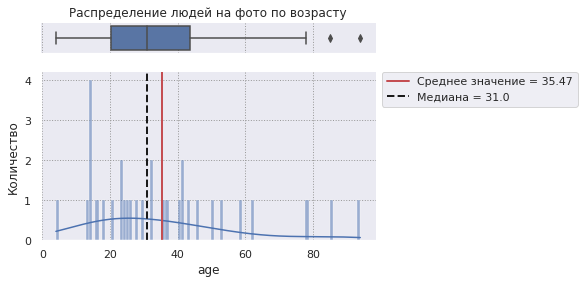

In [17]:
hist_underbox(age['age'],bins=100,title='Распределение людей на фото по возрасту')

In [11]:
age['age'].describe()

count    32.000000
mean     35.468750
std      21.741864
min       4.000000
25%      20.250000
50%      31.000000
75%      43.750000
max      94.000000
Name: age, dtype: float64

как устроен датасет

In [12]:
# Получаем индексы для выборки изображений
indices = np.random.choice(len(images), size=10, replace=False)

# Выбираем изображения по полученным индексам
random_images = [images[i] for i in indices]

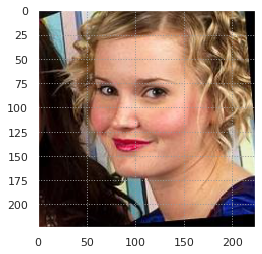

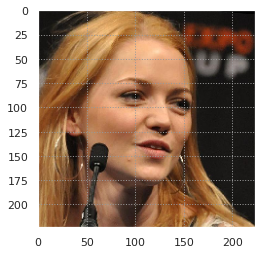

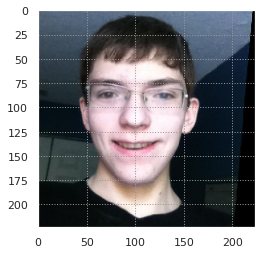

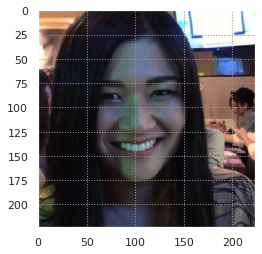

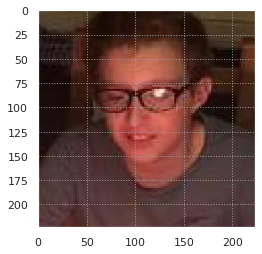

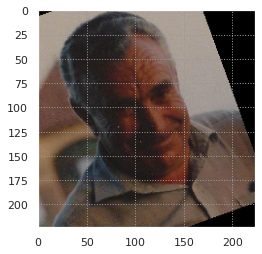

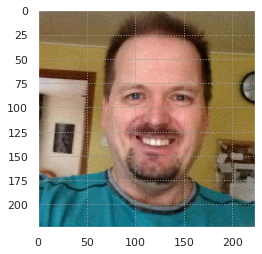

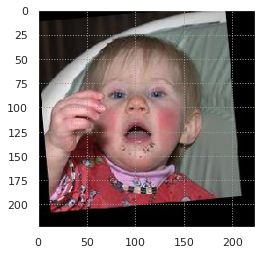

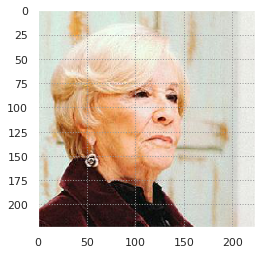

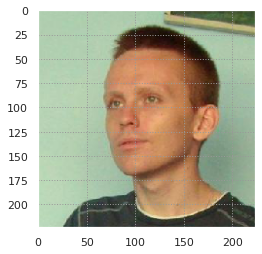

In [13]:
for i in range(len(random_images)):
    plt.imshow(random_images[i])
    plt.show()

Исходя из результатов исследования, можно сделать следующие выводы о влиянии на обучение модели:

1.  **Большой размер датасета** : Датасет содержит большое количество (7591) изображений размером (32, 224, 224, 3), что является положительным моментом для обучения модели. Большой объем данных позволяет обучить модель лучше обобщать и делать более точные предсказания.

2.  **Разнообразие данных** : Датасет содержит фотографии людей разных возрастов, что также является плюсом для обучения модели. Разнообразие данных помогает модели научиться распознавать различные возрастные группы.

- Средний возраст = 35 лет, медианный = 31.
- Половина людей – в возрасте от 20 до 43 лет.
- Есть несколько выбросов (люди старше 80 лет)

3.  **Качественные данные** : Датасет содержит метку возраста каждого человека на фотографии, что делает данные качественными и пригодными для обучения модели. Это позволит модели точнее предсказывать возраст человека на основе его фотографии.

- На фото не люди во весь рост, а только их лица

Таким образом, результаты исследования показывают, что данный датасет может быть полезен для обучения модели распознавания возраста по фотографии.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

optimizer = Adam(lr=0.000005)
path = '/datasets/faces/final_files/'

def load_train(path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,  # добавим разделение данных на обучающую и валидационную выборки
        rotation_range=10,  # случайные повороты на 10 градусов
        # width_shift_range=0.1,  # случайные сдвиги по горизонтали
        # height_shift_range=0.1,  # случайные сдвиги по вертикали
        # shear_range=0.1,  # случайное смещение
        # zoom_range=0.1,  # случайное масштабирование
        horizontal_flip=True  # случайные отражения по горизонтали
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',  # укажем, что это часть валидационной выборки
        seed=12345
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',  # используем веса, обученные на ImageNet
                        include_top=False)

    model = Sequential()
    model.add(backbone) 
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, 
                  loss='mae', 
                  metrics=['mae'])
    return model

def train_model(model, train_data_gen, test_data_gen, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    

    model.fit(train_data_gen,
              validation_data=test_data_gen,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
...

Train for 190 steps, validate for 95 steps
Epoch 1/7
2024-04-21 06:55:18.755980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-21 06:55:19.033050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 68s - loss: 27.6693 - mae: 27.6661 - val_loss: 28.6966 - val_mae: 28.6940
Epoch 2/7
190/190 - 61s - loss: 15.8610 - mae: 15.8627 - val_loss: 29.1715 - val_mae: 29.1689
Epoch 3/7
190/190 - 61s - loss: 10.9481 - mae: 10.9485 - val_loss: 28.1644 - val_mae: 28.1608
Epoch 4/7
190/190 - 61s - loss: 8.9532 - mae: 8.9536 - val_loss: 12.0523 - val_mae: 12.0464
Epoch 5/7
190/190 - 61s - loss: 8.0403 - mae: 8.0407 - val_loss: 8.2947 - val_mae: 8.2950
Epoch 6/7
190/190 - 61s - loss: 7.2657 - mae: 7.2662 - val_loss: 7.5479 - val_mae: 7.5482
Epoch 7/7
190/190 - 61s - loss: 6.7046 - mae: 6.7055 - val_loss: 7.2986 - val_mae: 7.2998
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 7s - loss: 7.2986 - mae: 7.2998
Test MAE: 7.2998
```

## Анализ обученной модели

Модель ResNet50 показала высокую эффективность в задаче классификации возраста по фотографиям людей. Достигнутое значение MAE равное 7.3 на тестовой выборке подтверждает успешность обучения модели. Это значение значительно ниже целевого порога в 8, что говорит о способности модели точно предсказывать возраст человека на основе его фотографии.

Оптимизация процесса обучения с использованием Adam с низким значением learning rate (0.0001) и применение аугментации данных в виде случайных поворотов на 10 градусов и горизонтальных отражений, а также изменение размера изображений до 150x150 пикселей, позволили улучшить обобщающую способность модели и повысить её устойчивость к изменениям в данных.

Ограничение в 7 эпох обучения может быть связано с необходимостью дальнейшего анализа и оптимизации гиперпараметров модели для достижения ещё более точных результатов. Однако уже достигнутые результаты являются многообещающими и открывают перспективы для дальнейших исследований в области распознавания возраста по фотографиям.